## Quantum energy teleportation protocol with minimal model

The minimal model is the simplest model capable of doing energy teleportation, it's composed of a system of two qubits.

### Import packages

Import necessary packages to create and simulate the protocol.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

### Theory

The energy of qubit B is $E_B = H_B + V$, where $H_B = h\sigma_Z^B + ...$ and $V = 2k\sigma^A_X\sigma^B_X + ...$. Since $\sigma_Z$ and $\sigma_X$ doesn't commute, two differents circuits are needed to measure the energy of a qubit.


In [7]:
from qiskit.quantum_info import Statevector, Operator

# Parameters
h = 1; k = 1; 

# Basis
ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)

# Operators
I = Operator.from_label('II').to_matrix();
Z_A = Operator.from_label('IZ').to_matrix(); Z_B = Operator.from_label('ZI').to_matrix();
X_AB = Operator.from_label('XX').to_matrix(); X_A = Operator.from_label('IX').to_matrix();
Y_B = Operator.from_label('YI').to_matrix()

# Ground state
ket_g = np.sqrt(1/2)*np.sqrt(1-h/np.sqrt(h**2+k**2))*ket_00 - np.sqrt(1/2)*np.sqrt(1+h/np.sqrt(h**2+k**2))*ket_11
state_g = Statevector(ket_g)
display('Ground State:', state_g.draw('latex'))

# Hamiltonians
H_A = h*Z_A + h**2/np.sqrt(h**2+k**2) * I
H_B = h*Z_B + h**2/np.sqrt(h**2+k**2) * I
V = 2*k*X_AB + 2*k**2/np.sqrt(h**2+k**2) * I

# Define angle phi
phi = np.arctan2(h*k, h**2 + 2*k**2)/2

# Define operations
def P_0(mi):
    """Projective measurement on qubit 0 or A"""
    return 1/2 * (I + mi*X_A)

def U_1(mi):
    """Conditional unitary operation"""
    return np.cos(phi) * I - 1j*mi*np.sin(phi) * Y_B

# Final State Density Matrix
P_QET = U_1(-1)@P_0(-1)@(ket_g@ket_g.conj().T)@P_0(-1)@U_1(-1).conj().T + U_1(+1)@P_0(+1)@(ket_g@ket_g.conj().T)@P_0(+1)@U_1(+1).conj().T
display('Final State:', Operator(P_QET).draw('latex'))

# Energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real # or -(h*k* np.sin(2*phi) - (h**2+2*k**2) * (1-np.cos(2*phi))) / np.sqrt(h**2 + k**2)

# Print results
print(f"""
Ground State Energies:
<H_A> = {ket_g.T@H_A@ket_g}
<H_B> = {ket_g.T@H_B@ket_g}
<V> = {ket_g.T@V@ket_g}
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
V = {E_V},
E_A = {E_A},
E_B = {E_B}
""")

'Ground State:'

<IPython.core.display.Latex object>

'Final State:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = [[0.+0.j]]
<H_B> = [[0.+0.j]]
<V> = [[-1.11022302e-16+0.j]]
            
Final Energies:
H_A = 0.7071067811865476,
H_B = 0.2598931856865896,
V = -0.374640819626737,
E_A = 0.3324659615598105,
E_B = -0.11474763394014753



### Function to generate a circuit that measures the local term $\sigma_Z$ or $H_b$

This circuit implements the minimal model and measures $H_b$.

In [26]:
def qc_H(h,k):

    # Generate circuit
    qc = QuantumCircuit(2)

    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement on A
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,0,1)
    
    qc.x(0)
    qc.cry(2*phi,0,1)
    qc.x(0)

    # measurement of Bob's Z term
    qc.measure_all()

    return qc

### Function to generate a circuit that measures the interaction term $\sigma_X\sigma_X$ or $V$

This circuit is the same as above, but measures in the basis $\sigma_X$.

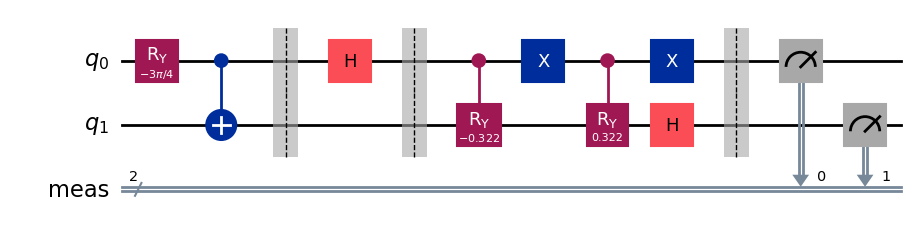

In [ ]:
def qc_V(h,k):

    # Create circuit
    qc = QuantumCircuit(2)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement of A
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,0,1)

    qc.x(0)
    qc.cry(2*phi,0,1)
    qc.x(0)

    # Measurement of the interaction term V
    qc.h(1)
    qc.measure_all()

    return qc

### Circuit for Estimator

In [20]:
def qc_T(h,k):

    # Create circuit
    qc = QuantumCircuit(2)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement of A
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,0,1)

    qc.x(0)
    qc.cry(2*phi,0,1)
    qc.x(0)

    # Measurement of the interaction term V
    qc.h(0)
    #qc.measure_all()

    return qc

### Show quantum circuit

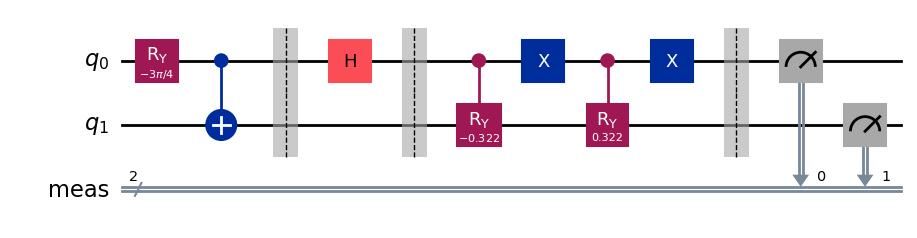

In [4]:
qc = qc_H(1, 1)
qc.draw('mpl')

### Simulate circuits with aer simulator

Simulates the circuits without noise but with statistical randomness. 

In [37]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1; k = 0.2;
n_shots = 100000

# Generate circuits
qc = qc_H(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)

qc = qc_V(h, k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = simulator.run([qc_B], shots=n_shots)
jobB_sim = simulator.run([qc_B], shots=n_shots)

### Show results for simulated circuit $H$

H_A = 0.9793406756909201 ± 0.0031622752290083795
H_B = 0.9733006756909202 ± 0.0031621938612298897


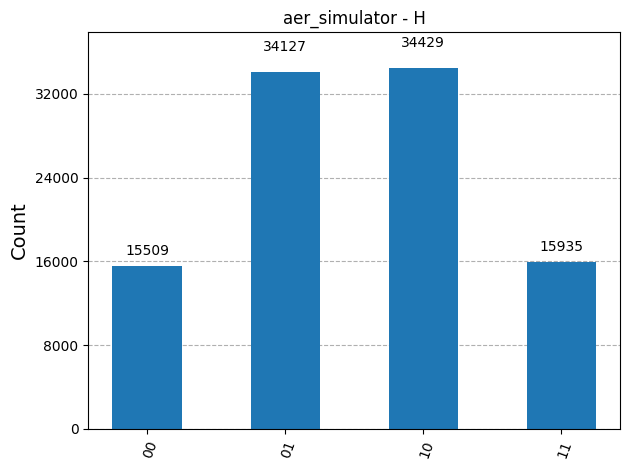

In [38]:
# Extract results
result = jobA_sim.result()
counts = result.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
#print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
print("H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator - H")

### Show results for simulated circuit V

V = -0.37930643762690514 ± 0.006324554863703848


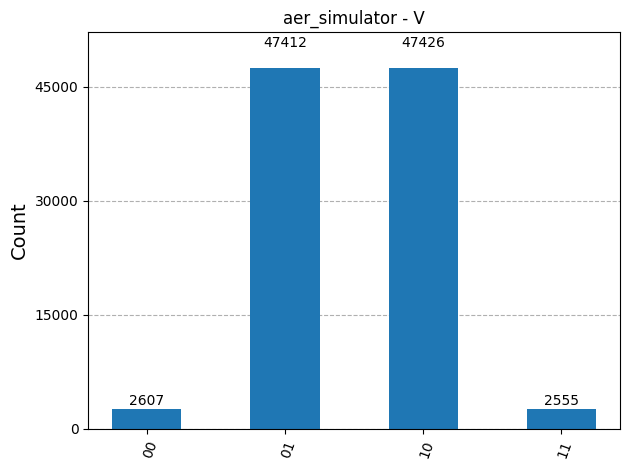

In [36]:
# Extract results
result = jobB_sim.result()
counts = result.get_counts()

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_V = []

# Calculate energies
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator - V')

### Get backend and its properties

Login the IBM Quantum Platform, selects the QPU with least number of jobs qeueded and shows some of its properties.

In [6]:
# Log in IBM platform
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy(operational=True)

# Get backend properties
props = backend.properties()

# Function to select specific properties
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Backend = {5}\n"
          "Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              backend.name))

describe_qubit(0, props)

C:\Users\julio\AppData\Local\Temp\ipykernel_15232\1821219519.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


Backend = ibm_brisbane
Qubit 0 has a 
  - T1 time of 116.4054772797434 microseconds
  - T2 time of 44.00809937781838 microseconds
  - U2 gate error of 0.00022439267322114942
  - U2 gate duration of 59.99999999999999 nanoseconds



### Run job with Sampler

Runs both circuits that measures $H_B$ and $V$ with the Sampler primitive.

In [ ]:
# Import Sampler 
from qiskit_ibm_runtime import Batch, SamplerV2 as sampler

# Parameters h and k
variables = [(1,0.2),(1,0.5),(1,1),(1.5,1),(1,1.5)]

#  Run job in Batch mode
with Batch(backend=backend):
    n_shots = 3000

    # initiate sampler and enable error mitigation
    sampler = sampler()
    options = sampler.options
    options.dynamical_decoupling.enable = True
    options.twirling.enable_gates = True

    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits H and V
        circuit_H = qc_H(h,k)
        transpiled_H = transpile(circuit_H, backend=backend, optimization_level=3)

        circuit_V = qc_V(h,k)
        transpiled_V = transpile(circuit_V, backend=backend, optimization_level=3)
        
        # Run jobs for each circuit
        job_H = sampler.run([(transpiled_H)], shots=n_shots)
        job_H.update_tags([f'k={k},h={h}', 'error mitigated','sampler','H', 'MM',f'{n_shots}'])  # Add tags to job
        print(f"Sampler H, ID = {job_H.job_id()}, h = {h} k = {k}")

        job_V = sampler.run([(transpiled_V)], shots=n_shots)
        job_V.update_tags([f'k={k},h={h}', 'error mitigated','sampler','V', 'MM'])  # Add tags to job
        print(f"Sampler V, ID = {job_V.job_id()}, h = {h} k = {k}")

### Run job with Estimator

Runs the appropriate circuit with the Estimator primitive.

In [215]:
# Import Estimator 
from qiskit_ibm_runtime import Batch, EstimatorV2 as estimator
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

# Parameters h and k
variables = [(1,0.2),(1,0.5),(1,1),(1.5,1),(1,1.5)]

transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

#  Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h = variable[0]
        k = variable[1]
        observables = [SparsePauliOp('ZI', h), SparsePauliOp('XX', 2*k)]

        # Generate circuit
        circuit_T = qc_T(h,k)
        qc_t = transpiler.run(circuit_T)
        
        # Run jobs
        transpiled_observable = observables[0].apply_layout(qc_t.layout)
        job_C = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)])
        job_C.update_tags([f'k={k},h={h}', 'error mitigated', 'estimator', 'H', 'MM']) # Add tags
        print(f"Estimator H, ID = {job_C.job_id()}, h = {h} k = {k}") 

        transpiled_observable = observables[1].apply_layout(qc_t.layout)
        job_D = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)]) 
        job_D.update_tags([f'k={k},h={h}', 'error mitigated', 'estimator', 'V', 'MM']) # Add tags
        print(f"Estimator V, ID = {job_D.job_id()}, h = {h} k = {k}") 

In [21]:
# Import Estimator 
from qiskit_ibm_runtime import Batch, EstimatorV2 as estimator
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

# Parameters h and k
#variables = [(1,0.2),(1,0.5),(1,1),(1.5,1),(1,1.5)]
variables = [(1,1)]

transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

#  Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h = variable[0]
        k = variable[1]
        observables = [SparsePauliOp('ZI', h), SparsePauliOp('XX', 2*k), SparsePauliOp('IZ', h)]

        # Generate circuit
        circuit_H = qc_H(h,k)
        qc_t = transpiler.run(circuit_H)

        circuit_V = qc_V(h,k)
        transpiled_V = transpiler.run(circuit_V)

        circuit_T = qc_T(h,k)
        qc_t = transpiler.run(circuit_T)
        
        # Run jobs
        transpiled_observable = observables[0].apply_layout(qc_t.layout)
        job_H = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)])
        job_H.update_tags([f'k={k},h={h}', 'error mitigated', 'estimator', 'B', 'MM']) # Add tags
        print(f"Estimator H, ID = {job_H.job_id()}, h = {h} k = {k}") 

        transpiled_observable = observables[1].apply_layout(qc_t.layout)
        job_V = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)]) 
        job_V.update_tags([f'k={k},h={h}', 'error mitigated', 'estimator', 'V', 'MM']) # Add tags
        print(f"Estimator V, ID = {job_V.job_id()}, h = {h} k = {k}") 

        transpiled_observable = observables[2].apply_layout(qc_t.layout)
        job_A = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)])
        job_A.update_tags([f'k={k},h={h}', 'error mitigated', 'estimator', 'A', 'MM']) # Add tags
        print(f"Estimator A, ID = {job_A.job_id()}, h = {h} k = {k}") 

Estimator H, ID = d0ydv3wvx7bg0082dmv0, h = 1 k = 1
Estimator V, ID = d0ydv5c7qc70008sddn0, h = 1 k = 1
Estimator A, ID = d0ydv6w1wej00089x070, h = 1 k = 1


### Show results for circuit H

H_A = 0.7019067811865476 ± 0.014141944420764775
Sampler B = 0.28510678118654736 ± 0.012821201191776066
Estimator B = 0.28940506043938174 ± 0.044136117833493256


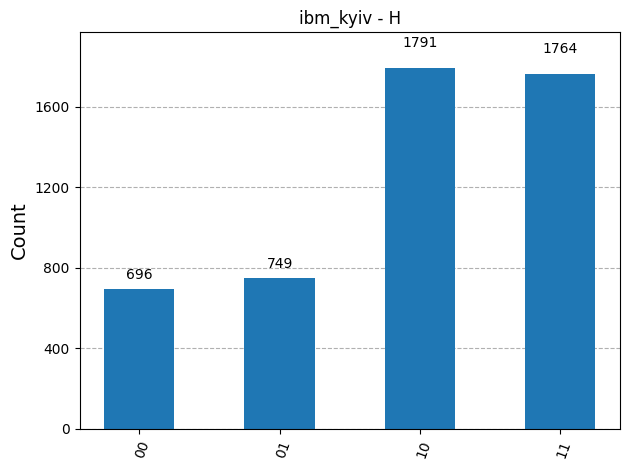

In [25]:
# Extract results

# Sampler
jobS = service.job('czzxtx3nhqag008v1a5g')
result = jobS.result()[0]
counts = result.data.meas.get_counts()

# Estimator
jobT = service.job('d0ydv3wvx7bg0082dmv0')
result = jobT.result()[0]
exp_value = result.data.evs
value_error = result.data.stds

# parameters
h = 1; k = 1;
n_shots = 5000

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))
est_B = exp_value + ene_B

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print(f"H_A = {ene_A} ± {np.std(error_A)/np.sqrt(n_shots)}")
print(f"Sampler B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"Estimator B = {est_B} ± {value_error}")

plot_histogram(counts, title=f"{jobS.backend().name} - H")

### Show results for circuit V

V = -0.32498643762690504 ± 0.028265112913271724
Estimated V = -0.33456180860668683 ± 0.0727060898394306


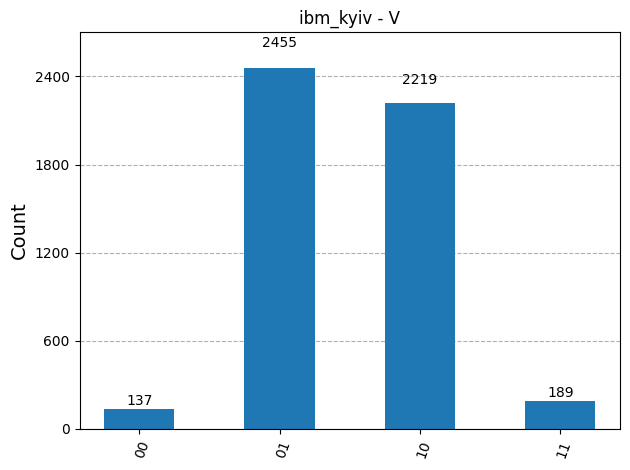

In [23]:
# Extract results

# Sampler
jobS = service.job('czzxtvknhqag008v1a40')
result = jobS.result()[0]
counts = result.data.meas.get_counts()

# Estimator
jobT = service.job('d0ydv5c7qc70008sddn0')
result = jobT.result()[0]
exp_value = result.data.evs
value_error = result.data.stds

# Parameters 
h = 1;k = 1;
n_shots = 5000

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))
est_V = exp_value + ene_V

# Erros arrays
error_V = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print(f"V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
print(f"Estimated V = {est_V} ± {value_error}")

plot_histogram(counts, title=f"{jobS.backend().name} - V")

## Extra: Initial ground state energy

Generate the ground state of the Minimal Model, simulate circuits to measure $H_A$, $H_B$ and $V$ and calculates $E_A$ and $E_B$

In [ ]:
from qiskit_aer.primitives import SamplerV2 as sampler

h = 1; k = 1;
theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

# Circuit V

qcV = QuantumCircuit(2)

# Prepare the ground state
qcV.ry(2*theta,0)
qcV.cx(0,1)

# Measure Energies
qcV.h(0)
qcV.h(1)
qcV.measure_all()

# Circuit H

qcH = QuantumCircuit(2)

# Prepare the ground state
qcH.ry(2*theta,0)
qcH.cx(0,1)

# Measure Energies
qcH.measure_all()

###################################################################################################################################################################################################

# Initiate simulator
simulator = AerSimulator()

# Parameters
n_shots = 100000

# Generate circuits
qcH = transpile(qcH, simulator, optimization_level=3)

qcV = transpile(qcV, simulator, optimization_level=3)

# Run job with Sampler
jobA = sampler().run([qcH], shots=n_shots)
jobB = sampler().run([qcV], shots=n_shots)

###################################################################################################################################################################################################
result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))


result = jobB.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Erros arrays
error_V = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

###################################################################################################################################################################################################
print("E_A =", ene_A + ene_V)
print("E_B =", ene_B + ene_V)

plot_histogram(counts)